In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
# connect data set using goggle drive
from google.colab import drive
drive.mount('/content/drive')


# Load dataset (Make sure to update file paths as needed)
train_df = pd.read_excel('/content/drive/MyDrive/Co2_Injection_Ml_Data_Xl/CO2_Injection_rate train.xlsx')
test_df = pd.read_excel('/content/drive/MyDrive/Co2_Injection_Ml_Data_Xl/CO2_Injection_rate test exam.xlsx')

# Data Cleaning and Preprocessing
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

# Feature Engineering: Creating Lag and Rolling Features
numerical_features = [col for col in train_df.columns if col not in ['Date Time', 'inj_diff']]

for col in numerical_features:
    train_df[f'{col}_lag_1'] = train_df[col].shift(1)
    train_df[f'{col}_lag_2'] = train_df[col].shift(2)
    train_df[f'{col}_rolling_mean'] = train_df[col].rolling(window=5).mean()
    train_df[f'{col}_rolling_std'] = train_df[col].rolling(window=5).std()

    if col in test_df.columns:
        test_df[f'{col}_lag_1'] = test_df[col].shift(1)
        test_df[f'{col}_lag_2'] = test_df[col].shift(2)
        test_df[f'{col}_rolling_mean'] = test_df[col].rolling(window=5).mean()
        test_df[f'{col}_rolling_std'] = test_df[col].rolling(window=5).std()

# Dropping NaN values caused by shifting
train_df.dropna(inplace=True)

# Splitting the data
X = train_df.drop(columns=['inj_diff', 'Date Time'])
y = train_df['inj_diff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for better ANN performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build Optimized ANN Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Train the ANN model
model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_test, y_test),
          verbose=1, callbacks=[early_stopping, lr_scheduler])

# Making Predictions
train_predictions = model.predict(X_test).flatten()

# Calculate R² Score and Accuracy Percentage
r2 = r2_score(y_test, train_predictions)
mae = mean_absolute_error(y_test, train_predictions)
accuracy_percentage = r2 * 100  # Convert R² to percentage
print(f'Validation R² Score: {r2:.4f} ({accuracy_percentage:.2f}%)')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Predicting on Test Data
test_features = test_df.drop(columns=['Date Time', 'inj_diff'], errors='ignore')  # Drop 'inj_diff' from test_features
# Ensure test_features has the same columns as X_train
test_features = scaler.transform(test_features[X.columns])
test_df['inj_diff_pred'] = model.predict(test_features).flatten()

# Saving Results
test_df[['Date Time', 'inj_diff_pred']].to_csv('CO2_injection_predictions.csv', index=False)
print("Predictions saved successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-6c5f2055244a>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'{col}_lag_2'] = train_df[col].shift(2)
<ipython-input-2-6c5f2055244a>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'{col}_rolling_mean'] = train_df[col].rolling(window=5).mean()
<ipython-input-2-6c5f2055244a>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instea

Epoch 1/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 16.3534 - mae: 1.9226 - val_loss: 17.6557 - val_mae: 1.7507 - learning_rate: 0.0010
Epoch 2/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 22.9218 - mae: 2.0316 - val_loss: 18.1489 - val_mae: 1.6472 - learning_rate: 0.0010
Epoch 3/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 18.9441 - mae: 1.8199 - val_loss: 17.1708 - val_mae: 1.6525 - learning_rate: 0.0010
Epoch 4/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 19.2722 - mae: 1.7986 - val_loss: 17.4070 - val_mae: 1.6737 - learning_rate: 0.0010
Epoch 5/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 21.4888 - mae: 1.8546 - val_loss: 17.2506 - val_mae: 1.7010 - learning_rate: 0.0010
Epoch 6/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 21.6573 - mae: 1.8583 - val_loss: 16.7082 - val_mae: 1.5967 - learning_rate: 0.0010
Epoch 7/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 16.8245 - mae: 1.6258 - val_loss: 16.6348 - val_mae: 1.6470 - learni

<ipython-input-2-6c5f2055244a>:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df['inj_diff_pred'] = model.predict(test_features).flatten()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# Load dataset (Make sure to update file paths as needed)
train_df = pd.read_excel('/content/drive/MyDrive/Co2_Injection_Ml_Data_Xl/CO2_Injection_rate train.xlsx')
test_df = pd.read_excel('/content/drive/MyDrive/Co2_Injection_Ml_Data_Xl/CO2_Injection_rate test exam.xlsx')

Descriptive Statistics for Training Data:


,Rand,inj_diff,Date Time,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,...,Avg_VW1_Z01D7061Tp_F_rolling_mean,Avg_VW1_Z01D7061Tp_F_rolling_std,Avg_VW1_Z0910D5482Ps_psi_lag_1,Avg_VW1_Z0910D5482Ps_psi_lag_2,Avg_VW1_Z0910D5482Ps_psi_rolling_mean,Avg_VW1_Z0910D5482Ps_psi_rolling_std,Avg_VW1_Z0910D5482Tp_F_lag_1,Avg_VW1_Z0910D5482Tp_F_lag_2,Avg_VW1_Z0910D5482Tp_F_rolling_mean,Avg_VW1_Z0910D5482Tp_F_rolling_std
count,1669.000000,1669.000000,1669,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,...,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000
mean,53086.560815,-0.008299,2024-12-31 08:36:25.020970496,0.000684,1157.887422,83.985206,619.241706,3220.409165,122.168439,2230.353489,...,122.771762,0.005787,2370.294676,2370.319979,2370.320010,0.282011,112.594195,112.593814,112.593809,0.017465
min,7300.000000,-34.435416,2024-11-22 08:00:00,0.000000,0.000000,0.000000,0.000000,2975.924015,106.764944,2196.804702,...,122.561630,0.000403,2328.654811,2328.654811,2344.334915,0.004071,111.007225,111.007225,111.752475,0.000821
25%,30710.000000,-0.314583,2024-12-12 13:00:00,0.000000,1101.832006,80.448647,556.629107,3193.141612,116.398042,2229.382701,...,122.698582,0.003488,2360.038883,2360.040883,2359.959878,0.027459,112.465059,112.465059,112.462039,0.003796
50%,53142.000000,0.000000,2024-12-31 11:00:00,0.000000,1222.263195,89.577187,600.452454,3246.214040,124.311821,2230.390916,...,122.786461,0.005186,2367.421802,2367.437561,2367.388561,0.041312,112.582061,112.581341,112.576178,0.005421
75%,75563.000000,0.343403,2025-01-19 15:00:00,0.000000,1292.933557,94.837440,653.770033,3264.086100,128.160618,2231.470610,...,122.842654,0.007371,2378.671800,2378.699782,2378.714691,0.062233,112.737940,112.737850,112.737291,0.008198
max,99977.000000,33.709375,2025-02-07 21:00:00,0.083333,2213.751686,100.211952,15236.162200,3454.144645,132.942493,2232.866056,...,122.960520,0.024536,2399.065426,2399.120473,2399.102733,16.198085,112.958725,112.958725,112.955751,0.773121
std,26542.553677,4.301153,NaN,0.005609,192.908647,16.939384,458.077758,86.416920,6.811153,2.204514,...,0.106093,0.003246,12.282885,12.296054,12.212771,1.573034,0.189937,0.189895,0.177134,0.074520



Descriptive Statistics for Test Data:


,Rand,Date Time,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,...,Avg_VW1_Z01D7061Tp_F_rolling_std,Avg_VW1_Z0910D5482Ps_psi_lag_1,Avg_VW1_Z0910D5482Ps_psi_lag_2,Avg_VW1_Z0910D5482Ps_psi_rolling_mean,Avg_VW1_Z0910D5482Ps_psi_rolling_std,Avg_VW1_Z0910D5482Tp_F_lag_1,Avg_VW1_Z0910D5482Tp_F_lag_2,Avg_VW1_Z0910D5482Tp_F_rolling_mean,Avg_VW1_Z0910D5482Tp_F_rolling_std,inj_diff_pred
count,149.000000,149,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,...,115.000000,148.000000,147.000000,145.000000,145.000000,148.000000,147.000000,145.000000,145.000000,115.000000
mean,3787.449664,2025-01-01 13:12:28.993288704,0.000559,1146.059696,81.775323,598.734128,3208.773534,122.610767,2230.050664,104.207437,...,0.099396,2369.088953,2369.173875,2369.110420,11.385352,112.588478,112.586611,112.591032,0.189441,5.655081
min,196.000000,2024-11-25 11:00:00,0.000000,0.000000,0.000000,0.000000,2976.817908,110.629932,2207.338444,103.185928,...,0.016624,2339.816165,2339.816165,2356.799893,2.373158,111.536938,111.536938,112.298419,0.050348,-0.841563
25%,1703.000000,2024-12-16 03:00:00,0.000000,1090.230581,79.803383,551.724058,3163.863527,115.938509,2229.363645,104.158611,...,0.080233,2359.990682,2360.202927,2366.214545,9.230871,112.468400,112.465262,112.543654,0.138574,3.825796
50%,4081.000000,2025-01-03 23:00:00,0.000000,1220.441339,87.347328,600.452462,3240.700564,124.582116,2230.354085,104.234226,...,0.103966,2366.012064,2366.258181,2369.396923,12.056622,112.579563,112.576330,112.594706,0.169588,5.829505
75%,5625.000000,2025-01-18 04:00:00,0.000000,1297.659337,94.914711,656.610666,3256.821895,128.178778,2231.580823,104.291407,...,0.127460,2376.451470,2376.770010,2372.291178,13.671912,112.739110,112.734880,112.646665,0.208739,7.512031
max,7270.000000,2025-02-07 10:00:00,0.066667,1348.453009,98.892860,741.179326,3441.434882,132.047157,2232.555436,104.360632,...,0.172635,2394.952588,2394.952588,2377.706288,20.950106,112.956085,112.956085,112.815672,0.518927,11.800135
std,2120.599878,NaN,0.005621,213.120445,19.899703,93.744523,97.097567,6.336912,3.151153,0.147497,...,0.032958,11.624942,11.618530,4.408088,3.412888,0.212411,0.211916,0.083531,0.095108,2.626873


<ipython-input-18-ceda17312638>:22: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


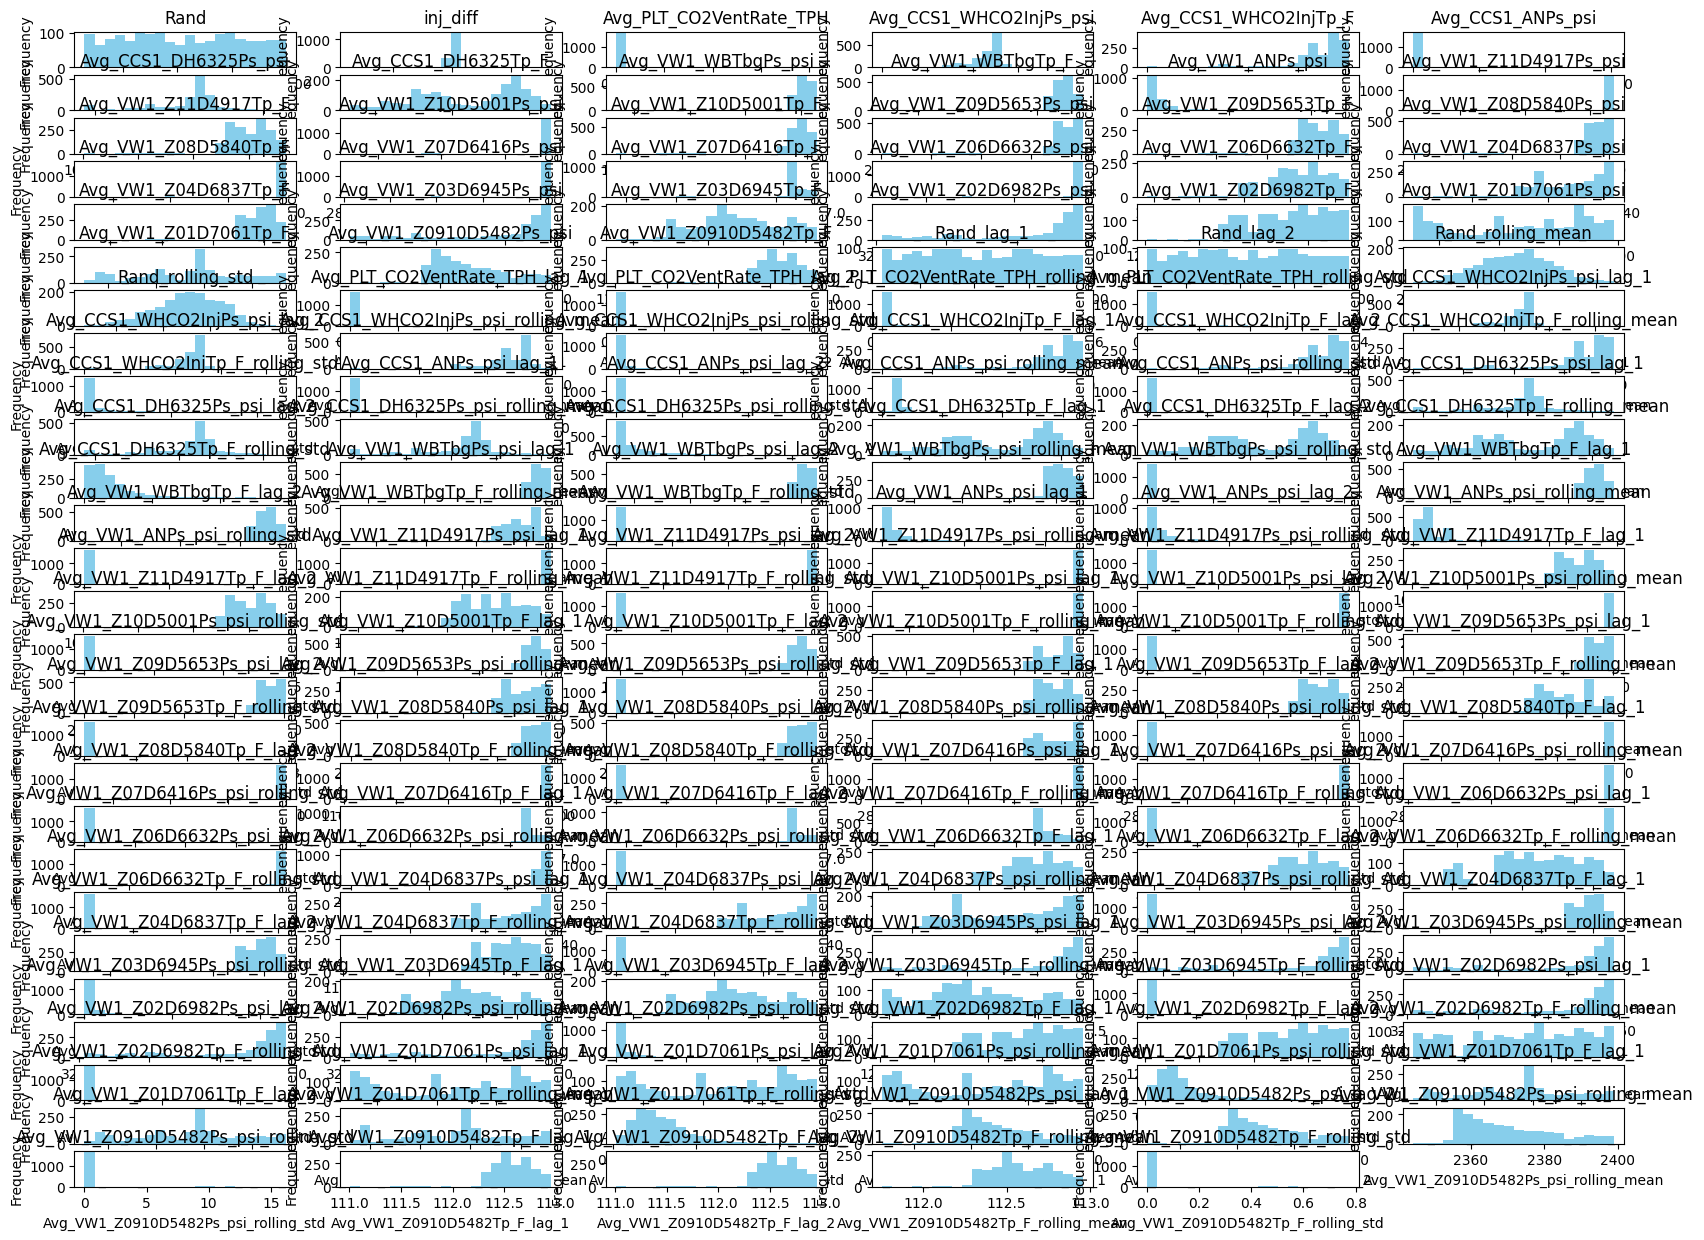

<ipython-input-18-ceda17312638>:32: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


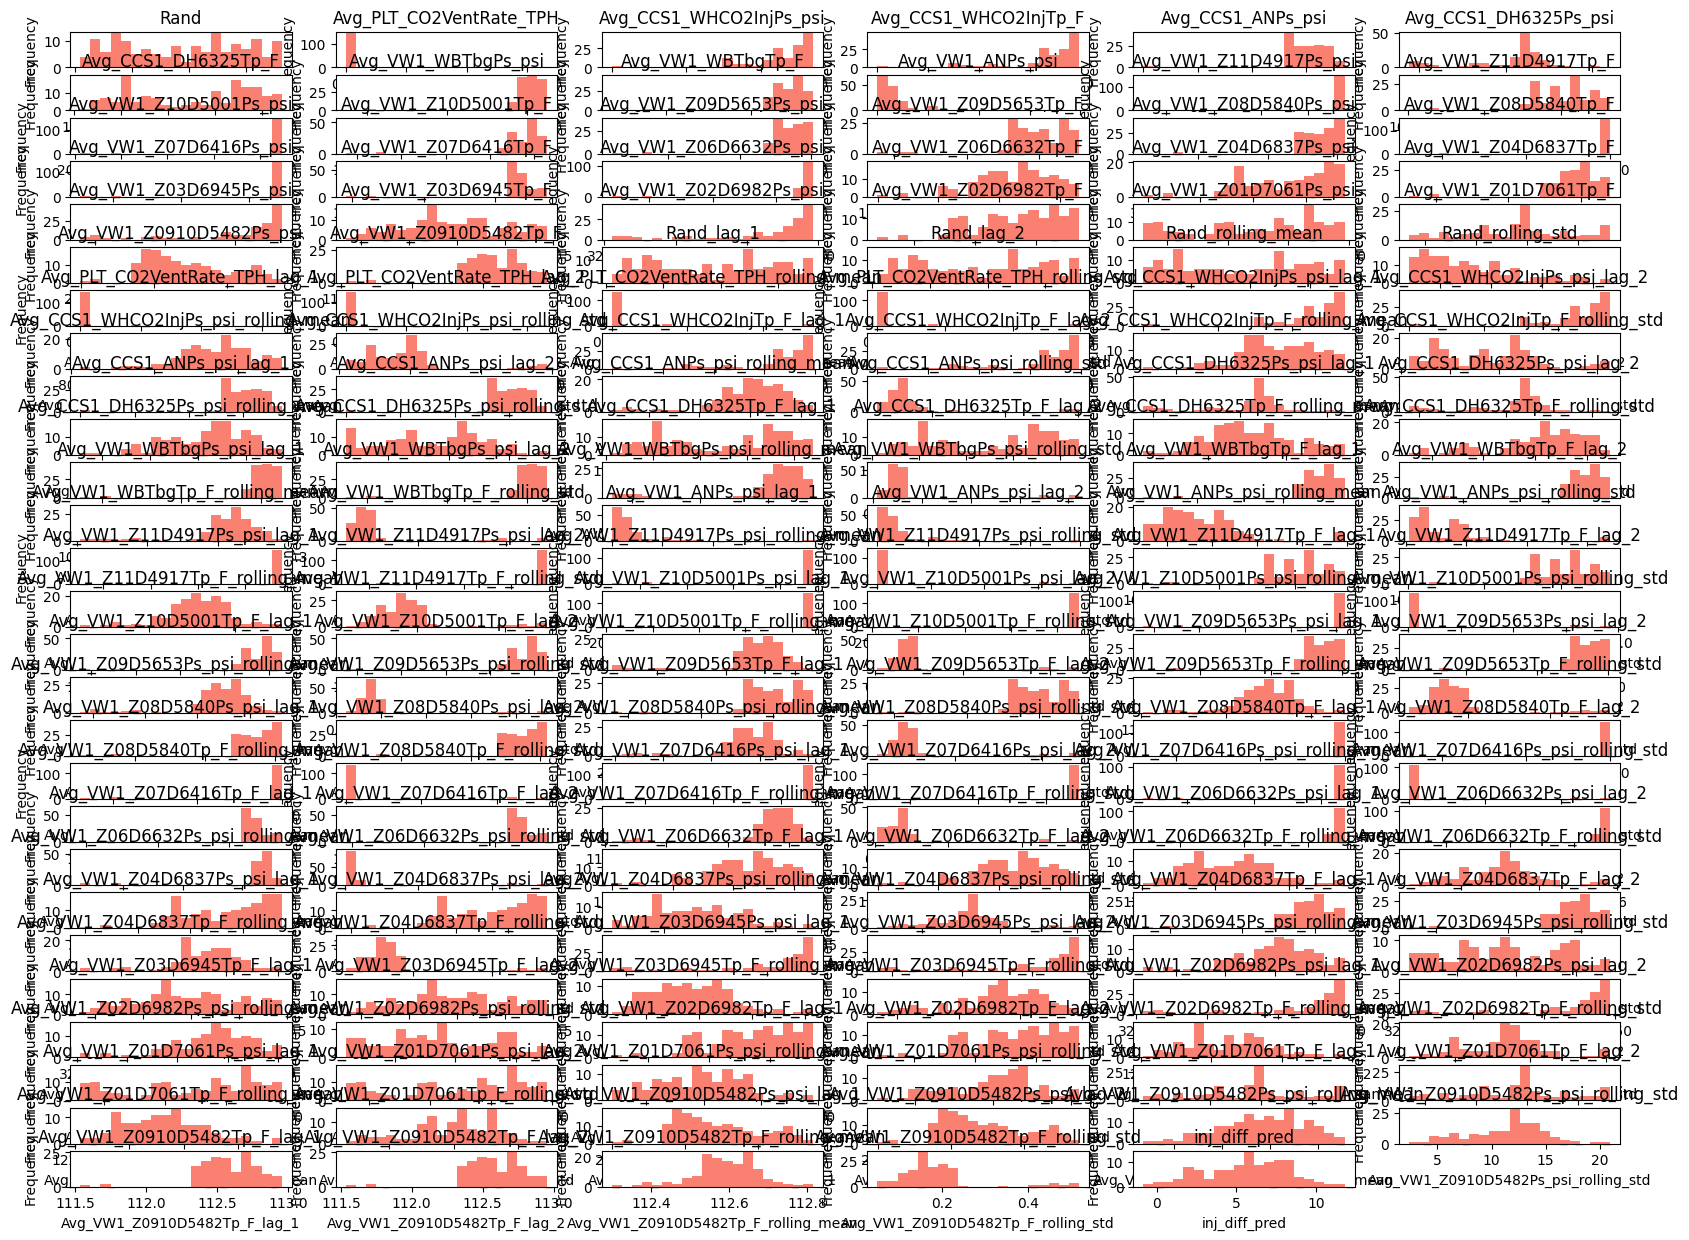

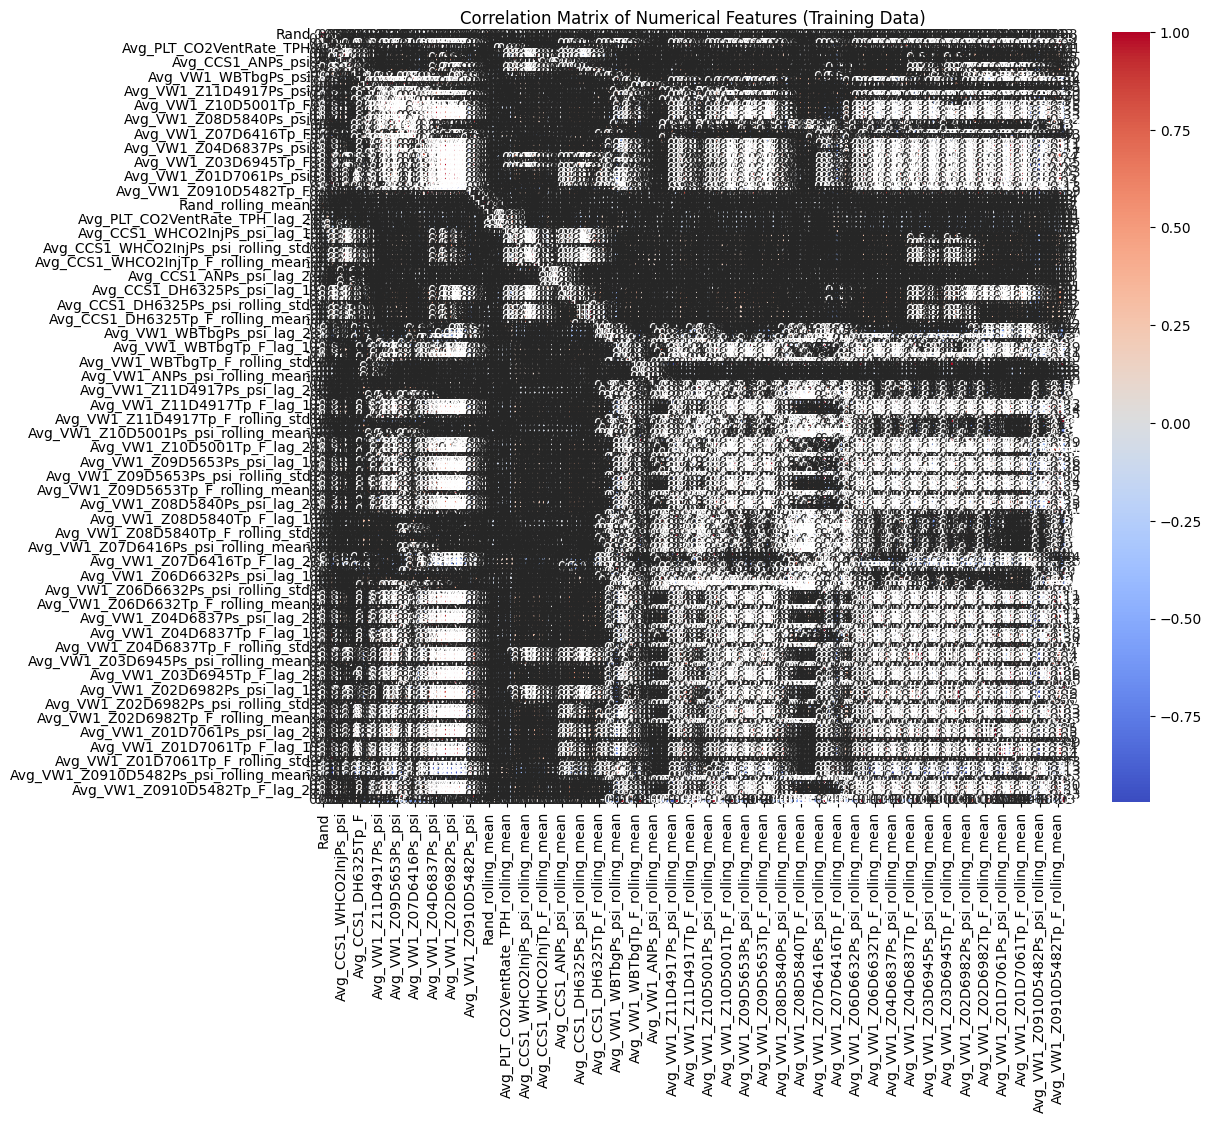


Highly Correlated Features with 'inj_diff':
 Avg_PLT_CO2VentRate_TPH_lag_1    0.180540
Avg_CCS1_ANPs_psi_lag_2          0.155158
Avg_CCS1_ANPs_psi                0.150238
Avg_PLT_CO2VentRate_TPH_lag_2    0.133102
Avg_PLT_CO2VentRate_TPH          0.132187
Name: inj_diff, dtype: float64


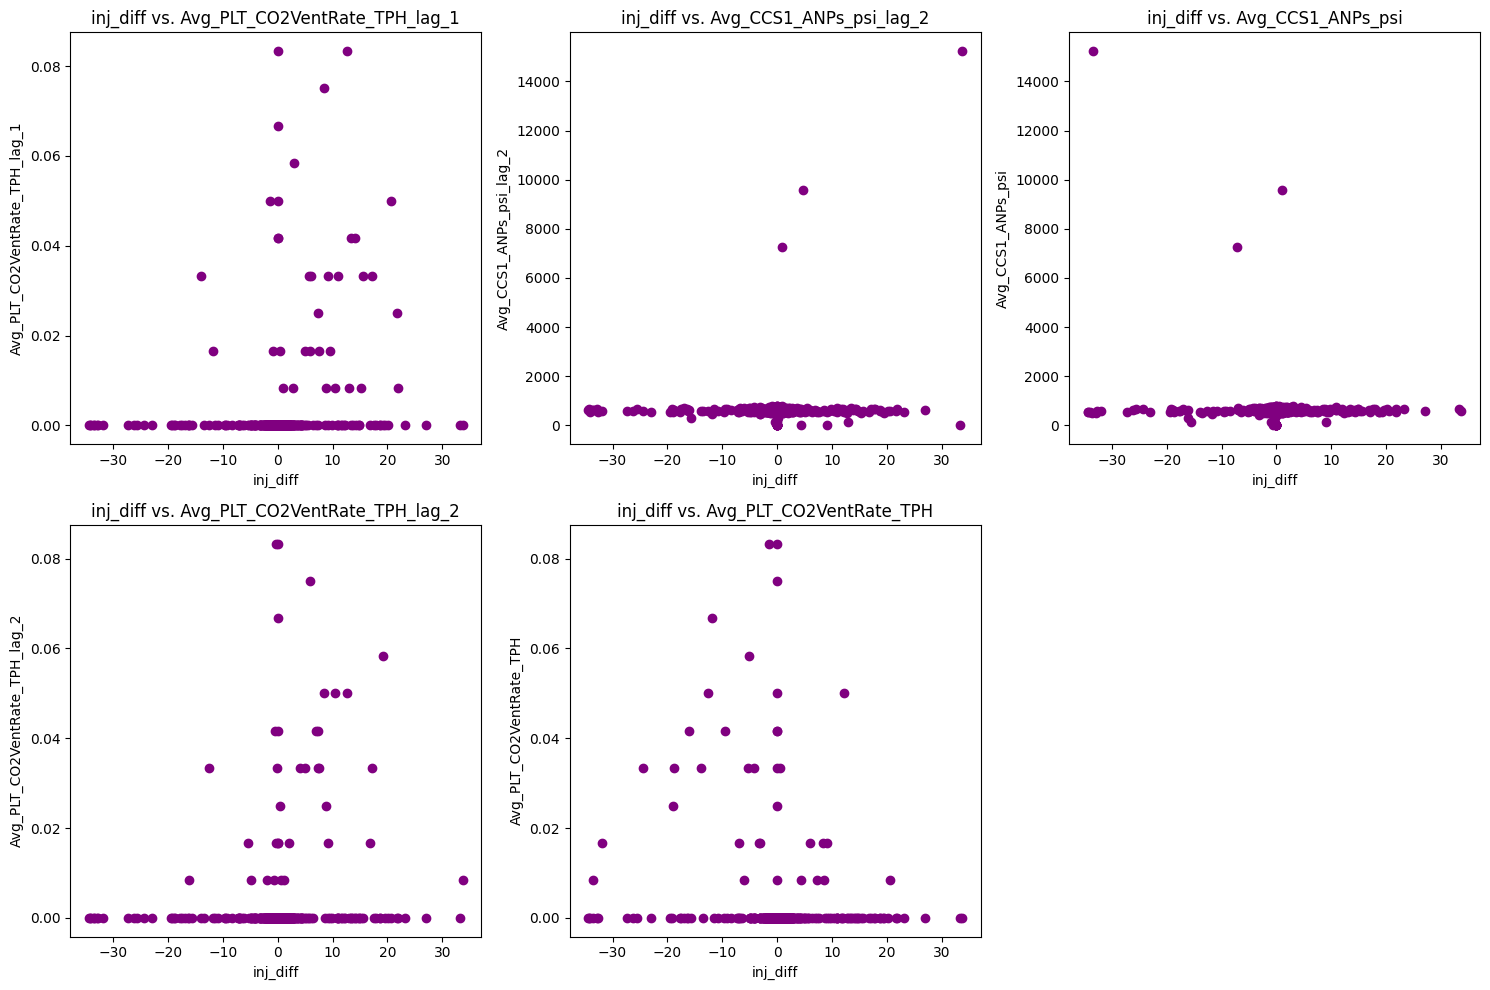


Shape of Training Data: (1669, 162)

Information of Training Data:
<class 'pandas.core.frame.DataFrame'>
Index: 1669 entries, 4 to 1712
Columns: 162 entries, Rand to Avg_VW1_Z0910D5482Tp_F_rolling_std
dtypes: datetime64[ns](1), float64(160), int64(1)
memory usage: 2.1 MB


None


Shape of Test Data: (149, 162)

Information of Test Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Columns: 162 entries, Rand to inj_diff_pred
dtypes: datetime64[ns](1), float32(1), float64(159), int64(1)
memory usage: 188.1 KB


None

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Descriptive Statistics
print("Descriptive Statistics for Training Data:")
display(train_df.describe()) # Changed df_train to train_df
print("\nDescriptive Statistics for Test Data:")
display(test_df.describe())  # Changed df_test to test_df

# Data Distribution Visualization - Histograms
num_cols = len(train_df.select_dtypes(include=['number']).columns)
num_rows = int(math.ceil(num_cols / 6))  # Calculate rows needed

plt.figure(figsize=(20, 15))
for i, col in enumerate(train_df.select_dtypes(include=['number']).columns):
    plt.subplot(num_rows, 6, i + 1)  # Adjust subplot grid
    plt.hist(train_df[col], bins=20, color='skyblue')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 15))
for i, col in enumerate(test_df.select_dtypes(include=['number']).columns): # Changed df_test to test_df
    plt.subplot(num_rows, 6, i + 1)
    plt.hist(test_df[col], bins=20, color='salmon') # Changed df_test to test_df
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()





# Correlation Analysis
correlation_matrix = train_df.corr() # Changed df_train to train_df
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features (Training Data)')
plt.show()

# Identify highly correlated features with 'inj_diff'
highly_correlated_features = correlation_matrix['inj_diff'].abs().sort_values(ascending=False)[1:6] # Exclude 'inj_diff' itself
print("\nHighly Correlated Features with 'inj_diff':\n", highly_correlated_features)

# Scatter plots of 'inj_diff' vs. highly correlated features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(highly_correlated_features.index):
    plt.subplot(2, 3, i + 1)
    plt.scatter(train_df['inj_diff'], train_df[feature], color='purple') # Changed df_train to train_df
    plt.title(f'inj_diff vs. {feature}')
    plt.xlabel('inj_diff')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()


# Data Shape and Information
print("\nShape of Training Data:", train_df.shape) # Changed df_train to train_df
print("\nInformation of Training Data:")
display(train_df.info()) # Changed df_train to train_df

print("\nShape of Test Data:", test_df.shape) # Changed df_test to test_df
print("\nInformation of Test Data:")
display(test_df.info()) # Changed df_test to test_df

In [62]:
# Impute missing values
for col in train_df.select_dtypes(include=['number']):
    train_df[col] = train_df[col].fillna(train_df[col].median())
for col in test_df.select_dtypes(include=['number']):
    test_df[col] = test_df[col].fillna(test_df[col].median())

# Outlier handling using IQR method
for col in train_df.select_dtypes(include=['number']):
    if col != 'Rand' and col != 'inj_diff':
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        train_df[col] = train_df[col].clip(lower=lower_bound, upper=upper_bound)
        test_df[col] = test_df[col].clip(lower=lower_bound, upper=upper_bound)

# Remove duplicates
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

# Convert 'Date Time' column to datetime objects
train_df['Date Time'] = pd.to_datetime(train_df['Date Time'])
test_df['Date Time'] = pd.to_datetime(test_df['Date Time'])

display(train_df.head())
display(test_df.head())

,Rand,inj_diff,Date Time,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,...,DayOfYear_cos,Avg_CCS1_ANPs_psi_lag1,Avg_PLT_CO2VentRate_TPH_lag1,Avg_CCS1_ANPs_psi_lag2,Avg_PLT_CO2VentRate_TPH_lag2,Avg_CCS1_ANPs_psi_lag3,Avg_PLT_CO2VentRate_TPH_lag3,Avg_CCS1_ANPs_psi_lag7,Avg_PLT_CO2VentRate_TPH_lag7,Interaction_ANPs_VentRate
4,13827,0.639583,2024-11-22 08:00:00,0.0,1114.396364,76.466836,686.325817,3315.742818,106.941482,2232.518034,...,0.793572,605.542108,0.0,605.588034,0.0,605.614656,0.0,605.663398,0.0,0.0
5,27292,0.352430,2024-11-22 09:00:00,0.0,1115.969922,75.538491,702.283712,3318.165875,107.467359,2232.623039,...,0.793572,686.325817,0.0,605.588034,0.0,605.614656,0.0,605.663398,0.0,0.0
6,77239,0.004514,2024-11-22 10:00:00,0.0,1113.909782,75.532998,699.748619,3317.304738,107.710560,2232.616772,...,0.793572,702.283712,0.0,686.325817,0.0,605.614656,0.0,605.663398,0.0,0.0
7,76156,0.144445,2024-11-22 11:00:00,0.0,1111.690773,74.453041,691.645811,3319.333234,107.792787,2232.568717,...,0.793572,699.748619,0.0,702.283712,0.0,686.325817,0.0,605.663398,0.0,0.0
8,41443,-1.301562,2024-11-22 12:00:00,0.0,1131.269511,74.254189,681.546714,3313.474451,107.695053,2232.586841,...,0.793572,691.645811,0.0,699.748619,0.0,702.283712,0.0,605.663398,0.0,0.0


,Rand,Date Time,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,...,DayOfYear_cos,Avg_CCS1_ANPs_psi_lag1,Avg_PLT_CO2VentRate_TPH_lag1,Avg_CCS1_ANPs_psi_lag2,Avg_PLT_CO2VentRate_TPH_lag2,Avg_CCS1_ANPs_psi_lag3,Avg_PLT_CO2VentRate_TPH_lag3,Avg_CCS1_ANPs_psi_lag7,Avg_PLT_CO2VentRate_TPH_lag7,Interaction_ANPs_VentRate
0,196,2024-12-03 18:00:00,0.0,815.179680,58.865456,549.814482,3086.724880,115.486600,2231.816545,104.111751,...,0.893919,605.052509,0.0,605.449385,0.0,605.666491,0.0,605.444737,0.0,0.0
1,199,2025-01-25 21:00:00,0.0,1107.391891,80.355995,582.318649,3240.670603,116.430401,2229.016689,104.330812,...,0.908818,549.814482,0.0,605.449385,0.0,605.666491,0.0,605.444737,0.0,0.0
2,434,2024-12-16 21:00:00,0.0,1325.434039,95.655190,662.075168,3282.452722,127.412783,2231.374359,104.182041,...,0.971100,582.318649,0.0,549.814482,0.0,605.666491,0.0,605.444737,0.0,0.0
3,443,2024-12-08 19:00:00,0.0,1226.120394,88.926430,562.333082,3259.085547,122.714026,2232.036442,104.105361,...,0.929141,662.075168,0.0,582.318649,0.0,549.814482,0.0,605.444737,0.0,0.0
4,644,2025-01-22 09:00:00,0.0,1155.092736,86.224892,621.546616,3190.583272,122.441536,2229.860781,104.325892,...,0.929141,562.333082,0.0,662.075168,0.0,582.318649,0.0,605.444737,0.0,0.0


In [63]:
import numpy as np
import pandas as pd

# Convert 'Date Time' to datetime objects
train_df['Date Time'] = pd.to_datetime(train_df['Date Time'])  # Use pd.to_datetime()
test_df['Date Time'] = pd.to_datetime(test_df['Date Time'])

# Time-Based Features
train_df['DayOfWeek'] = train_df['Date Time'].dt.dayofweek
train_df['Month'] = train_df['Date Time'].dt.month
train_df['Hour'] = train_df['Date Time'].dt.hour
train_df['DayOfYear'] = train_df['Date Time'].dt.dayofyear

test_df['DayOfWeek'] = test_df['Date Time'].dt.dayofweek
test_df['Month'] = test_df['Date Time'].dt.month
test_df['Hour'] = test_df['Date Time'].dt.hour
test_df['DayOfYear'] = test_df['Date Time'].dt.dayofyear

# Cyclical features for hour and day of year
train_df['Hour_sin'] = np.sin(2 * np.pi * train_df['Hour'] / 24)
train_df['Hour_cos'] = np.cos(2 * np.pi * train_df['Hour'] / 24)
train_df['DayOfYear_sin'] = np.sin(2 * np.pi * train_df['DayOfYear'] / 365)
train_df['DayOfYear_cos'] = np.cos(2 * np.pi * train_df['DayOfYear'] / 365)

test_df['Hour_sin'] = np.sin(2 * np.pi * test_df['Hour'] / 24)
test_df['Hour_cos'] = np.cos(2 * np.pi * test_df['Hour'] / 24)
test_df['DayOfYear_sin'] = np.sin(2 * np.pi * test_df['DayOfYear'] / 365)
test_df['DayOfYear_cos'] = np.cos(2 * np.pi * test_df['DayOfYear'] / 365)

# Lagged Features
for lag_days in [1, 2, 3, 7]:
    train_df[f'Avg_CCS1_ANPs_psi_lag{lag_days}'] = train_df['Avg_CCS1_ANPs_psi'].shift(lag_days)
    test_df[f'Avg_CCS1_ANPs_psi_lag{lag_days}'] = test_df['Avg_CCS1_ANPs_psi'].shift(lag_days)
    train_df[f'Avg_PLT_CO2VentRate_TPH_lag{lag_days}'] = train_df['Avg_PLT_CO2VentRate_TPH'].shift(lag_days)  # Add lagged VentRate
    test_df[f'Avg_PLT_CO2VentRate_TPH_lag{lag_days}'] = test_df['Avg_PLT_CO2VentRate_TPH'].shift(lag_days)  # Add lagged VentRate


# Rolling Statistics
window_size = 7
train_df['Avg_CCS1_ANPs_psi_rolling_mean'] = train_df['Avg_CCS1_ANPs_psi'].rolling(window=window_size).mean()
train_df['Avg_CCS1_ANPs_psi_rolling_std'] = train_df['Avg_CCS1_ANPs_psi'].rolling(window=window_size).std()
test_df['Avg_CCS1_ANPs_psi_rolling_mean'] = test_df['Avg_CCS1_ANPs_psi'].rolling(window=window_size).mean()
test_df['Avg_CCS1_ANPs_psi_rolling_std'] = test_df['Avg_CCS1_ANPs_psi'].rolling(window=window_size).std()

# Interaction Terms
train_df['Interaction_ANPs_VentRate'] = train_df['Avg_CCS1_ANPs_psi'] * train_df['Avg_PLT_CO2VentRate_TPH']
test_df['Interaction_ANPs_VentRate'] = test_df['Avg_CCS1_ANPs_psi'] * test_df['Avg_PLT_CO2VentRate_TPH']

# Fill NaN values created by lagging and rolling
for df in [train_df, test_df]:
    for col in df.columns:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].mean()) # or df[col].fillna(method='ffill')

display(train_df.head())
display(test_df.head())

,Rand,inj_diff,Date Time,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,...,DayOfYear_cos,Avg_CCS1_ANPs_psi_lag1,Avg_PLT_CO2VentRate_TPH_lag1,Avg_CCS1_ANPs_psi_lag2,Avg_PLT_CO2VentRate_TPH_lag2,Avg_CCS1_ANPs_psi_lag3,Avg_PLT_CO2VentRate_TPH_lag3,Avg_CCS1_ANPs_psi_lag7,Avg_PLT_CO2VentRate_TPH_lag7,Interaction_ANPs_VentRate
4,13827,0.639583,2024-11-22 08:00:00,0.0,1114.396364,76.466836,686.325817,3315.742818,106.941482,2232.518034,...,0.793572,605.542108,0.0,605.588034,0.0,605.614656,0.0,605.663398,0.0,0.0
5,27292,0.352430,2024-11-22 09:00:00,0.0,1115.969922,75.538491,702.283712,3318.165875,107.467359,2232.623039,...,0.793572,686.325817,0.0,605.588034,0.0,605.614656,0.0,605.663398,0.0,0.0
6,77239,0.004514,2024-11-22 10:00:00,0.0,1113.909782,75.532998,699.748619,3317.304738,107.710560,2232.616772,...,0.793572,702.283712,0.0,686.325817,0.0,605.614656,0.0,605.663398,0.0,0.0
7,76156,0.144445,2024-11-22 11:00:00,0.0,1111.690773,74.453041,691.645811,3319.333234,107.792787,2232.568717,...,0.793572,699.748619,0.0,702.283712,0.0,686.325817,0.0,605.663398,0.0,0.0
8,41443,-1.301562,2024-11-22 12:00:00,0.0,1131.269511,74.254189,681.546714,3313.474451,107.695053,2232.586841,...,0.793572,691.645811,0.0,699.748619,0.0,702.283712,0.0,605.663398,0.0,0.0


,Rand,Date Time,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,...,DayOfYear_cos,Avg_CCS1_ANPs_psi_lag1,Avg_PLT_CO2VentRate_TPH_lag1,Avg_CCS1_ANPs_psi_lag2,Avg_PLT_CO2VentRate_TPH_lag2,Avg_CCS1_ANPs_psi_lag3,Avg_PLT_CO2VentRate_TPH_lag3,Avg_CCS1_ANPs_psi_lag7,Avg_PLT_CO2VentRate_TPH_lag7,Interaction_ANPs_VentRate
0,196,2024-12-03 18:00:00,0.0,815.179680,58.865456,549.814482,3086.724880,115.486600,2231.816545,104.111751,...,0.893919,605.052509,0.0,605.449385,0.0,605.666491,0.0,605.444737,0.0,0.0
1,199,2025-01-25 21:00:00,0.0,1107.391891,80.355995,582.318649,3240.670603,116.430401,2229.016689,104.330812,...,0.908818,549.814482,0.0,605.449385,0.0,605.666491,0.0,605.444737,0.0,0.0
2,434,2024-12-16 21:00:00,0.0,1325.434039,95.655190,662.075168,3282.452722,127.412783,2231.374359,104.182041,...,0.971100,582.318649,0.0,549.814482,0.0,605.666491,0.0,605.444737,0.0,0.0
3,443,2024-12-08 19:00:00,0.0,1226.120394,88.926430,562.333082,3259.085547,122.714026,2232.036442,104.105361,...,0.929141,662.075168,0.0,582.318649,0.0,549.814482,0.0,605.444737,0.0,0.0
4,644,2025-01-22 09:00:00,0.0,1155.092736,86.224892,621.546616,3190.583272,122.441536,2229.860781,104.325892,...,0.929141,562.333082,0.0,662.075168,0.0,582.318649,0.0,605.444737,0.0,0.0


In [64]:
train_df.dropna(inplace=True)

In [65]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = train_df.drop(['inj_diff', 'Date Time'], axis=1)
y = train_df['inj_diff']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Display shapes of resulting datasets to verify the split
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (1335, 184)
X_val shape: (334, 184)
y_train shape: (1335,)
y_val shape: (334,)


In [66]:
# Build Optimized ANN Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1)  # Output layer
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Train the ANN model
model.fit(X_train, y_train, epochs=300, batch_size=8, validation_data=(X_val, y_val),
          verbose=1, callbacks=[early_stopping, lr_scheduler])

Epoch 1/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 2.4252 - mae: 1.2134 - val_loss: 1.9694 - val_mae: 0.8316 - learning_rate: 0.0010
Epoch 2/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2147 - mae: 0.8629 - val_loss: 0.5563 - val_mae: 0.5743 - learning_rate: 0.0010
Epoch 3/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.8319 - mae: 0.7149 - val_loss: 0.5196 - val_mae: 0.5444 - learning_rate: 0.0010
Epoch 4/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6692 - mae: 0.6436 - val_loss: 0.5310 - val_mae: 0.5485 - learning_rate: 0.0010
Epoch 5/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6094 - mae: 0.6104 - val_loss: 0.5134 - val_mae: 0.5388 - learning_rate: 0.0010
Epoch 6/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5578 - mae: 0.5815 - val_loss: 0.5088 - val_mae: 0.5280 - learning_rate: 0.0010
Epoch 7/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5085 - mae: 0.5514 - val_loss: 0.5146 - val_mae: 0.5277 - learning_rate: 0.001

In [71]:
import numpy as np

# Get the training columns used when fitting the scaler
train_columns = X_train.columns  # Columns used during training

# Ensure test_features has ONLY the columns used in training (drop extra columns)
test_features = test_df[train_columns.intersection(test_df.columns)]

# Add missing columns (if any) with default values (zero or mean)
for col in train_columns:
    if col not in test_features.columns:
        test_features[col] = 0  # Alternative: use X_train[col].mean() if preferred

# Reorder columns to match training data
test_features = test_features[train_columns]

# Scale the test features using the same scaler fitted on training data
test_features_scaled = scaler.transform(test_features)

# Making predictions on the validation set
train_predictions = model.predict(X_val).flatten()

# Calculate R² Score and Accuracy Percentage
r2 = r2_score(y_val, train_predictions)
mae = mean_absolute_error(y_val, train_predictions)
accuracy_percentage = r2 * 100  # Convert R² to percentage
print(f'Validation R² Score: {r2:.4f} ({accuracy_percentage:.2f}%)')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Now, make predictions on the test data using the scaled test features
test_df['inj_diff_pred'] = model.predict(test_features_scaled).flatten()

# Saving Results
test_df[['Date Time', 'inj_diff_pred']].to_csv('CO2_injection_predictions.csv', index=False)
print("Predictions saved successfully.")




ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Avg_CCS1_ANPs_psi_lag1
- Avg_CCS1_ANPs_psi_lag2
- Avg_CCS1_ANPs_psi_lag3
- Avg_CCS1_ANPs_psi_lag7
- Avg_PLT_CO2VentRate_TPH_lag1
- ...
